````
AESM1450 - Geophysical Prospecting  -- Controlled-Source ElectroMagnetic (CSEM) Modelling
````
# 6. Inversion

Using the same data as in the previous exercise, we now run some VERY simple inversions on it using built-in routines in SciPy.

In [1]:
import empymod
import numpy as np
import xarray as xr
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('default')

## Load data

In [3]:
with xr.open_dataset('./data/Data-3D.nc', engine='h5netcdf') as ds:
    dataset = ds.data.loc[:, :, b'ex', :]

In [4]:
# Choose a source and receiver position for this inversion
src_name = b'Tx001'
rec_name = b'Rx005'

# Get the data
data = dataset.loc[src_name, rec_name, :]
vdata = dataset.loc[src_name, rec_name, :].values

# Extract their coordinates
src = [data.srcx.values, data.srcy.values, data.srcz.values]
rec = [data.recx.values, data.recy.values, data.recz.values]

# Extract frequencies
freqs = data.frequency.values

cmp = (src[0]+rec[0])/2

print(f"Src-x : {src[0]:5.0f} m")
print(f"Rec-x : {rec[0]:5.0f} m")
print(f"CMP   : {cmp:5.0f} m")
print("Responses:")
for i, f in enumerate(freqs):
    print(f"{f:5.2} Hz: {vdata[i].real:8.1e}{vdata[i].imag:+8.1e}j")

Src-x :     0 m
Rec-x :  5000 m
CMP   :  2500 m
Responses:
  0.1 Hz:  2.1e-14-2.3e-13j
  0.5 Hz: -2.6e-15+2.9e-14j
  1.0 Hz:  3.3e-15-2.0e-15j


# 1D Model

In [5]:
# Depth model

#depth = -np.arange(21)*100-2000
depth = -np.r_[2000, 2500, 3000, 3500, 3600, 3700, 3800]

# Starting resistivities

#res0 = np.r_[0.3, np.ones(21)]
res0 = np.r_[0.3, np.ones(7)]

# Depths and resistivity for plotting
pdepth = np.r_[-1800, np.c_[depth, depth].ravel(), -4200]
pres0 = np.c_[res0, res0].ravel()

# Check

We create forward data from our initial model `res1d`, and also calculate this starting model with `empymod`. This way we can check if our mesh is good enough.

In [6]:
# empymod 1D for comparison
epm_bg = empymod.dipole(src, rec, depth, res0, freqs, verb=1)

<IPython.core.display.Javascript object>


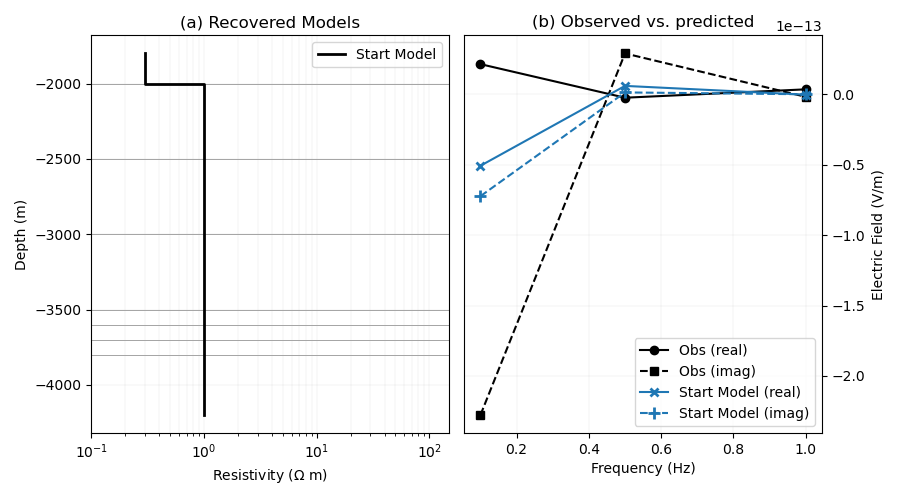

In [7]:
plt.figure(figsize=(9, 5))

# Model
ax1 = plt.subplot(121)
plt.title("(a) Recovered Models")

# Background model
plt.plot(pres0, pdepth, 'k-', lw=2, label="Start Model")
for d in depth:
    plt.axhline(d, c='.5', lw=0.5, zorder=0)

plt.legend()
plt.xscale('log')
plt.xlim([0.1, 150])
plt.xlabel('Resistivity ($\Omega$ m)')
plt.ylabel('Depth (m)')
ax1.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)


# Data
ax2 = plt.subplot(122)
plt.title("(b) Observed vs. predicted")

# Observed data
plt.plot(freqs, vdata.real, 'ko-', label="Obs (real)")
plt.plot(freqs, vdata.imag, 'ks--', label="Obs (imag)")

# Inversion result
plt.plot(freqs, epm_bg.real, 'C0x-', mew=2, label="Start Model (real)")
plt.plot(freqs, epm_bg.imag, 'C0+--', mew=2, ms=8, label="Start Model (imag)")

#plt.yscale('symlog', linthreshy=1e-13)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Electric Field (V/m)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)

plt.tight_layout()
plt.show()

# Invert brute force

In [8]:
def forward(x, inp):
    return empymod.dipole(res=10**x, **inp)
    
    
def misfit(x, istart, iend, inp, data):
    xx = np.log10(res0)
    xx[istart:iend] = x
    return np.linalg.norm(data-forward(xx, inp))/max(abs(data))

In [9]:
inp = {'src': src, 'rec': rec, 'depth': depth, 'freqtime': freqs, 'verb': 1}

istart = 4
iend = 6

ni = (iend-istart)
print(f"{ni} free layers: {depth[istart-1]} m to {depth[iend-1]} m")

# Resistivity boundaries for free layers
lower_bound = np.log10(1)    # Lower: 1 Ohm.m
upper_bound = np.log10(200)  # Upper: 200 Ohm.m

2 free layers: -3500 m to -3700 m


### Brute Force
Only feasible for very few layers.

In [10]:
%%time
ires = optimize.brute(misfit, ni*([lower_bound, upper_bound, (upper_bound-lower_bound)/11], ), 
                      (istart, iend, inp, data), finish=None)
print(ires)

[1.46429182 1.88266091]
CPU times: user 705 ms, sys: 0 ns, total: 705 ms
Wall time: 704 ms


### Least Squares

In [11]:
%%time
opt = optimize.least_squares(
    misfit, ni*[1.0, ], bounds=(lower_bound, upper_bound), args=(istart, iend, inp, data))

ires = opt['x']
print(ires)

[1.7433495  1.70265043]
CPU times: user 3.14 s, sys: 0 ns, total: 3.14 s
Wall time: 3.14 s


## Plot the results

In [12]:
res = np.log10(res0)
res[istart:iend] = ires
epm_i = forward(res, inp)
pres_i = 10**np.c_[res, res].ravel()

<IPython.core.display.Javascript object>


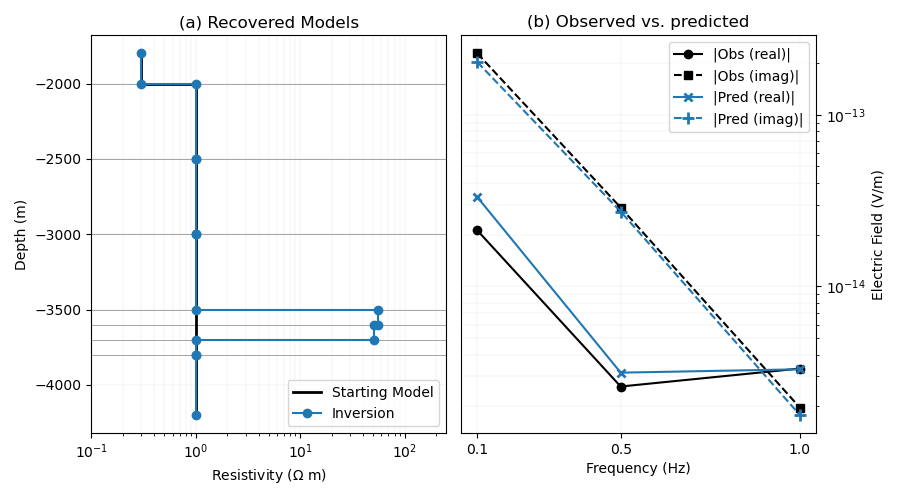

In [13]:
plt.figure(figsize=(9, 5))

# Model
ax1 = plt.subplot(121)
plt.title("(a) Recovered Models")

# Background model
plt.plot(pres0, pdepth, 'k-', lw=2, label="Starting Model")
for d in depth:
    plt.axhline(d, c='.5', lw=0.5, zorder=0)
    
# Inverted model
plt.plot(pres_i, pdepth, 'C0o-', ms=6, label='Inversion')

plt.legend()
plt.xscale('log')
plt.xlim([0.1, 250])
plt.xlabel('Resistivity ($\Omega$ m)')
plt.ylabel('Depth (m)')
ax1.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)


# Data
ax2 = plt.subplot(122)
plt.title("(b) Observed vs. predicted")

# Observed data
plt.plot(freqs, abs(vdata.real), 'ko-', label="|Obs (real)|")
plt.plot(freqs, abs(vdata.imag), 'ks--', label="|Obs (imag)|")

# Inversion result
plt.plot(freqs, abs(epm_i.real), 'C0x-', mew=2, label="|Pred (real)|")
plt.plot(freqs, abs(epm_i.imag), 'C0+--', mew=2, ms=8, label="|Pred (imag)|")

#plt.yscale('symlog', linthreshy=1e-13)
plt.legend()
plt.yscale('log')
plt.xticks(freqs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Electric Field (V/m)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)

plt.tight_layout()
plt.show()

## Create a cross-section for CMP, Tx001

In [14]:
rec_names = dataset.rec_name.values

result = np.ones((len(dataset.rec_name), res0.size))
result *= np.log10(res0[None, :])

In [15]:
def get_results(inpsrc, result):
    print(f"Invert for source :: {inpsrc}")
    for i, irec in enumerate(dataset.rec_name.values):
        print(f"         receiver :: {irec}")
        idata = dataset.loc[inpsrc, irec, :]
        isrc = [idata.srcx.values, idata.srcy.values, idata.srcz.values]
        irec = [idata.recx.values, idata.recy.values, idata.recz.values]
        iinp = {'src': isrc, 'rec': irec, 'depth': depth, 'freqtime': freqs, 'verb': 1}

        opt = optimize.least_squares(
            misfit, ni*[1.0, ], bounds=(lower_bound, upper_bound),
            args=(istart, iend, iinp, idata.values))

        result[i, istart:iend] = opt['x']
    return result
        

In [16]:
%%time
result1 = get_results(b'Tx001', result.copy())
result2 = get_results(b'Tx002', result.copy())

Invert for source :: b'Tx001'
         receiver :: b'Rx001'
         receiver :: b'Rx002'
         receiver :: b'Rx003'
         receiver :: b'Rx004'
         receiver :: b'Rx005'
         receiver :: b'Rx006'
         receiver :: b'Rx007'
         receiver :: b'Rx008'
         receiver :: b'Rx009'
Invert for source :: b'Tx002'
         receiver :: b'Rx001'
         receiver :: b'Rx002'
         receiver :: b'Rx003'
         receiver :: b'Rx004'
         receiver :: b'Rx005'
         receiver :: b'Rx006'
         receiver :: b'Rx007'
         receiver :: b'Rx008'
         receiver :: b'Rx009'
CPU times: user 10.9 s, sys: 3.15 ms, total: 10.9 s
Wall time: 10.9 s


<IPython.core.display.Javascript object>


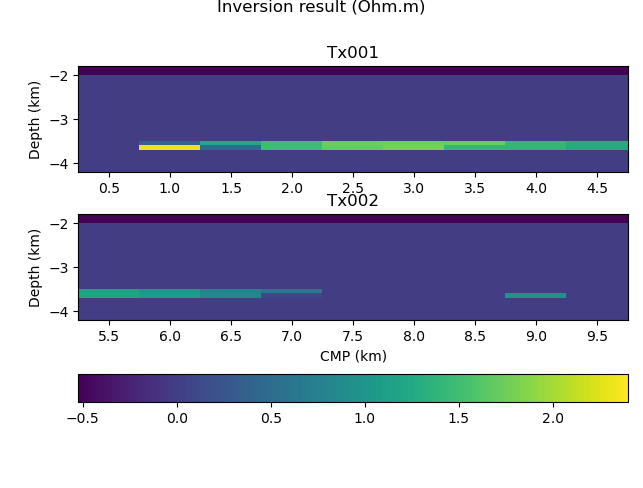

In [17]:
pseudox = np.arange(10)
pseudoy = np.r_[pdepth[::2], pdepth[-1]]/1e3
vmin = np.log10(0.3)
vmax = np.log10(250)

fig = plt.figure()
plt.suptitle('Inversion result (Ohm.m)', y=1)

ax1 = plt.subplot(211)
plt.title('Tx001')

cf0 = plt.pcolormesh(pseudox, pseudoy, result1.T, vmin=vmin, vmax=vmax)

plt.xticks(np.arange(9)+0.5, np.arange(1, 10)/2)

plt.ylabel('Depth (km)')

ax2 = plt.subplot(212)
plt.title('Tx002')

cf0 = plt.pcolormesh(pseudox, pseudoy, result2.T, vmin=vmin, vmax=vmax)

plt.xticks(np.arange(9)+0.5, np.arange(1, 10)/2+5)

plt.xlabel('CMP (km)')
plt.ylabel('Depth (km)')

plt.tight_layout()
plt.colorbar(cf0, ax=[ax1, ax2], orientation='horizontal')
plt.show()

# Task

In this simple example we exactly KNEW, which layer the target could be. How does the inversion result change if you leave more layers *free** (play with `istart` and `iend`).

In [18]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Wed Feb 17 13:55:13 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 05:05:16)
  [GCC 9.3.0]

             numpy : 1.19.5
             scipy : 1.6.0
             numba : 0.51.2
           empymod : 2.0.3
           IPython : 7.19.0
        matplotlib : 3.3.3

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------